##  訓練データとテストデータを作る際のデータサンプリングついて
[3.1. Cross-validation: evaluating estimator performance — scikit-learn 0.18.1 documentation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

### ランダムなサンプリング
[sklearn.cross_validation.train_test_split — scikit-learn 0.18.1 documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html)

### クラスタを考慮したランダムサンプリング
[sklearn.cross_validation.StratifiedShuffleSplit — scikit-learn 0.17.1 documentation](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html#sklearn.cross_validation.StratifiedShuffleSplit)

In [334]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import seaborn as sns

from sklearn.cross_validation import train_test_split
import seaborn as sns

exp_values = [
    'C(Pclass)',
    'C(Sex)',
    'C(Child)',
    'C(Embarked)'
]
predict_value = 'Survived'
child_threthold = 16


def output_result(model, category_data, base_data):
    result = model.predict(category_data)
    with open('data/result.csv', 'w') as f:
        f.write('PassengerId,Survived\n')
        for r, pid in zip(result, base_data['PassengerId']):
            f.write('{},{}\n'.format(pid, str(int(r))))


def category_to_table(titanic, is_training_data=True):
    fomula = '+'.join(exp_values)
    if is_training_data:
        fomula = fomula + '+' + predict_value

    print('fomula:', fomula)

    c_df = patsy.dmatrix(fomula, data=titanic, return_type='dataframe')
    return c_df


def load_titanic_data(is_training_data=True):
    """
    データを読みこみ、
    必要なパラメータに絞る
    """
    def is_child(age):
        if pd.isnull(age):
            return False
        if age < child_threthold:
            return True
        return False
    
    titanic = None
    if is_training_data:
        titanic = pd.read_csv("data/train.csv")
    else:
        titanic = pd.read_csv("data/test.csv")

    if is_training_data:
        titanic = titanic.dropna(
            subset=['Age', 'Sex', 'Pclass']
        )
    titanic = titanic.assign(
        Child=titanic['Age'].map(is_child)
    )
    return titanic


def hit_rate(predict, test):
    N = len(predict)
    hit = sum([1 if p == t else 0 for p, t in zip(predict, test)])
    return hit/N * 1.0


def main():
    titanic = load_titanic_data()
    titanic_category = category_to_table(titanic)

    x_columns = list(titanic_category.columns)
    x_columns.remove(predict_value)

    X_train, X_test, Y_train, Y_test = train_test_split(titanic[x_columns],
                                                        titanic[predict_value],
                                                        test_size=0.4,
                                                        random_state=0)


titanic = load_titanic_data()
titanic.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Child
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False


In [335]:
## カテゴリカルなデータに変換
titanic_category = category_to_table(titanic)
titanic_category.head(2)

fomula: C(Pclass)+C(Sex)+C(Child)+C(Embarked)+Survived


,Intercept,C(Pclass)[T.2],C(Pclass)[T.3],C(Sex)[T.male],C(Child)[T.True],C(Embarked)[T.Q],C(Embarked)[T.S],Survived
0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [336]:
x_columns = list(titanic_category.columns)
x_columns.remove(predict_value)
x_columns

['Intercept',
 'C(Pclass)[T.2]',
 'C(Pclass)[T.3]',
 'C(Sex)[T.male]',
 'C(Child)[T.True]',
 'C(Embarked)[T.Q]',
 'C(Embarked)[T.S]']

## ランダムサンプリング

In [337]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(titanic_category[x_columns],
                                                                                        titanic_category[predict_value],
                                                                                        test_size=0.4,
                                                                                        random_state=0)

print(len(X_train), len(X_test))

training_titanic = titanic.query('PassengerId in @train_user')
test_titanic = titanic.query('PassengerId not in @train_user')

## データに偏りがないかを調べる
pd.concat([X_train.sum(), X_test.sum()], axis=1)

427 285


,0,1
Intercept,427.0,285.0
C(Pclass)[T.2],106.0,67.0
C(Pclass)[T.3],219.0,136.0
C(Sex)[T.male],277.0,176.0
C(Child)[T.True],53.0,30.0
C(Embarked)[T.Q],16.0,12.0
C(Embarked)[T.S],328.0,226.0


### train_test_split によって、偏りが少ないサンプルデータセットが作れた！！

### 前回と同じように決定木を作ってみる


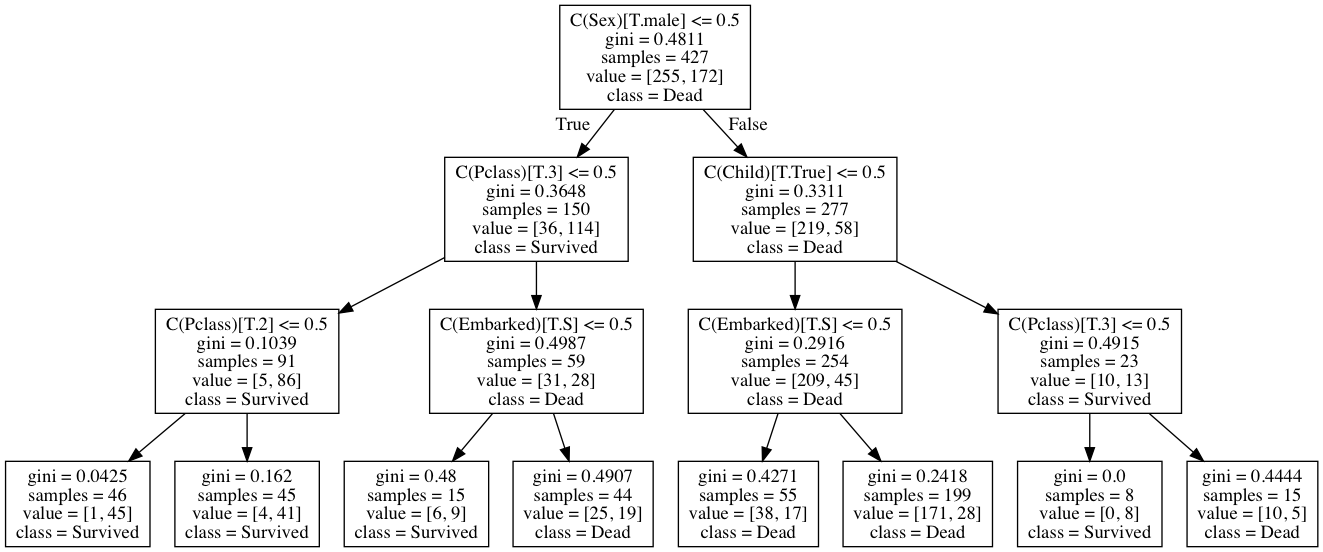

In [143]:
import patsy
from sklearn import tree
from sklearn.feature_extraction import DictVectorizer

decision_tree_model = tree.DecisionTreeClassifier(max_depth=3)
decision_tree_model.fit(X_train, Y_train)

# 描画
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
tree.export_graphviz(
    decision_tree_model,
    out_file=dot_data,
    feature_names=list(X_train.keys()),
    class_names=['Dead', 'Survived']
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

In [144]:
predict = decision_tree_model.predict(X_test)
hit_rate(predict, Y_test) 

0.8210526315789474

traning_testデータへのfit が82%。　前回は半分に分けたときに54%だったのでかなり良くなった。

In [93]:
titanic_test = load_titanic_data(False)
test_data = category_to_table(titanic_test, False)
test_data
result = decision_tree_model.predict(test_data)
with open('data/result.csv', 'w') as f:
    f.write('PassengerId,Survived\n')
    for r, pid in zip(result, titanic_test['PassengerId']):
        f.write('{},{}\n'.format(pid, str(int(r))))

fomula: C(Pclass)+C(Sex)+C(Child)+C(Embarked)


## サンプリングの仕方はめちゃくちゃ大事！！！！
同じアルゴリズム・パラメータでも
正しくテストデータを
サンプリングするだけで全然違う

## 50.7% -> 78.9%

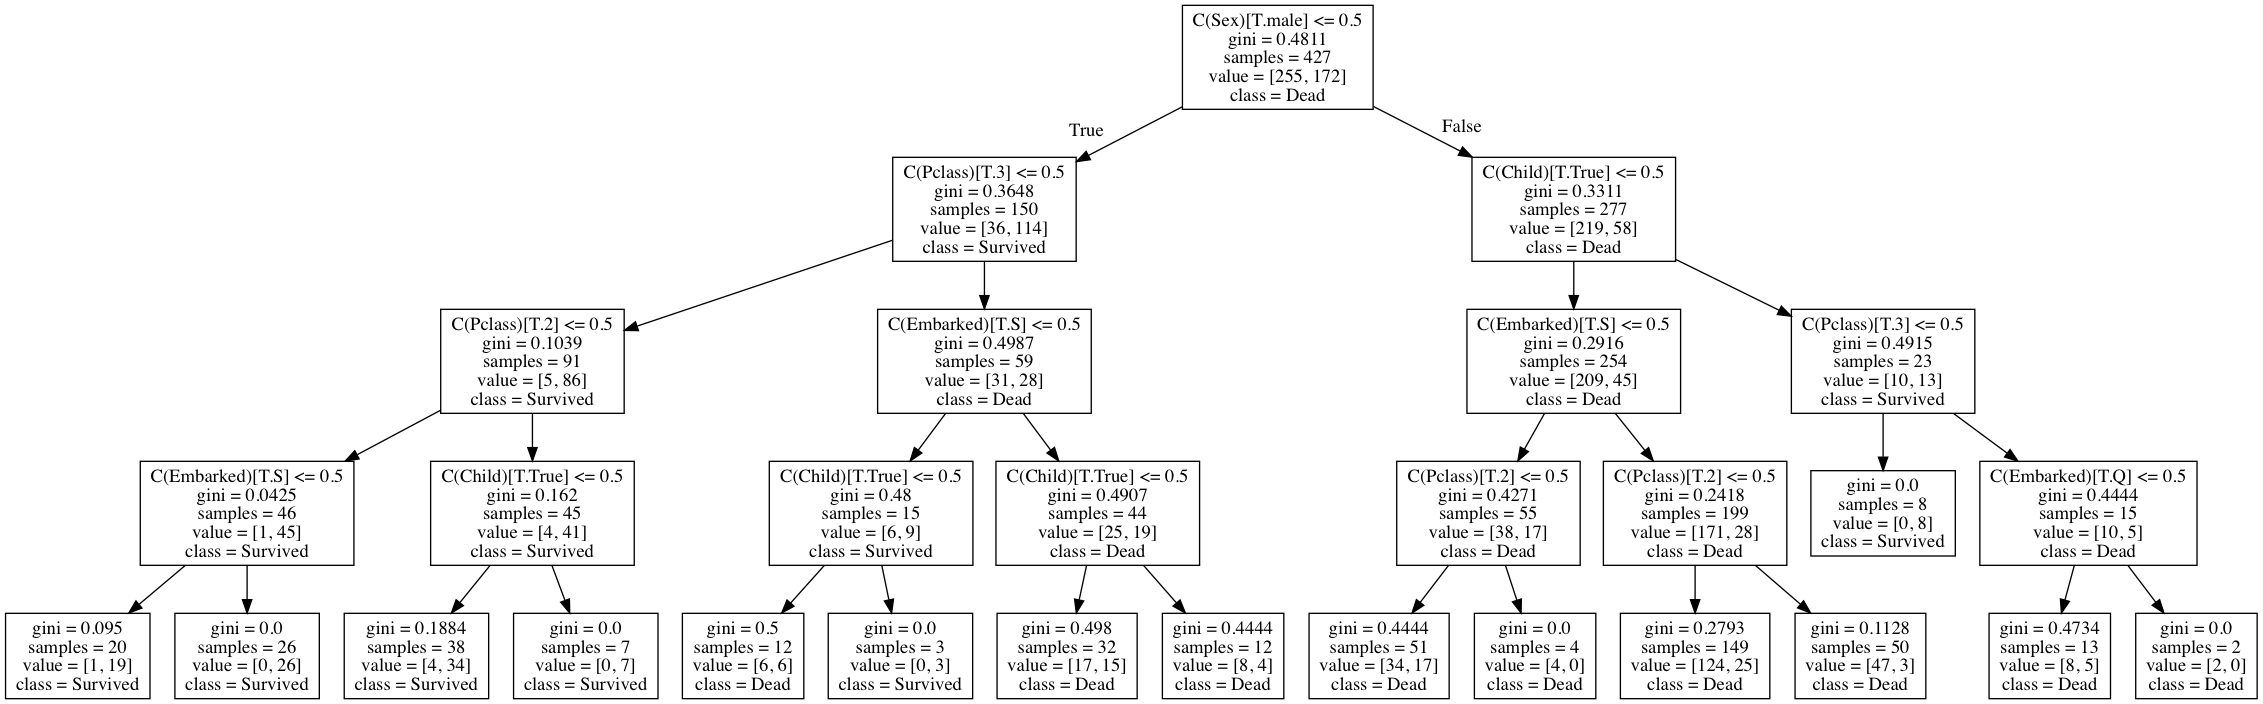

In [138]:
import patsy
from sklearn import tree
from sklearn.feature_extraction import DictVectorizer

decision_tree_model_4 = tree.DecisionTreeClassifier(max_depth=4)
decision_tree_model_4.fit(X_train, Y_train)

# 描画
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
tree.export_graphviz(
    decision_tree_model_4,
    out_file=dot_data,
    feature_names=list(X_train.keys()),
    class_names=['Dead', 'Survived']
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [141]:
predict_decision_tree_4 = decision_tree_model_4.predict(X_test)
hit_rate(predict_decision_tree_4, Y_test) 
output_result(decision_tree_model_4, test_data, titanic_test)

## ランダムフォレスト

なんだかいい感じにしてくれちゃうランダムフォレスト。
試してみようではないか・・・・。

In [111]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(n_estimators=30, random_state=0)
random_forest_model.fit(X_train, Y_train)

predict_random_forest = random_forest_model.predict(X_test)
hit_rate(predict_random_forest, Y_test) 

0.8175438596491228

In [122]:
output_result(random_forest_model, test_data, titanic_test)

In [123]:
## SVC
from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(X_train, Y_train)

predict_svc = svc_model.predict(X_test)
hit_rate(predict_svc, Y_test) 
output_result(svc_model, test_data, titanic_test)

## 手法とパラメータによる違い
|手法|パラメータ|結果|
|:--|:--|:--|
|決定木|深さ3|78.9%|
|決定木|深さ4|77.0%|
|ランダムフォレスト|estimator=default|77.9%|
|ランダムフォレスト|estimator=30|78.4%|
|SVM||77.0%|

## どこが一致してないのか考えてみよう？

予想: Class3の女性


In [209]:
random_forest_result = X_test.assign(
    Survived=Y_test,
    Result=predict_random_forest
)

random_forest_result = random_forest_result.assign(
    Match=random_forest_result['Survived']==random_forest_result['Result']
)

match = random_forest_result.groupby([
                             'C(Pclass)[T.2]',
                            'C(Pclass)[T.3]',
                            'C(Sex)[T.male]',
                            'C(Child)[T.True]',
                            'C(Embarked)[T.Q]',
                            'C(Embarked)[T.S]', 'Match'])[['Survived']].agg(['mean', 'count'])

match
# random_forest_result['Match'] = random_forest_result['Survived==Result']
# random_forest_result.head(3)

Survived  \
                                                                                                          mean   
C(Pclass)[T.2] C(Pclass)[T.3] C(Sex)[T.male] C(Child)[T.True] C(Embarked)[T.Q] C(Embarked)[T.S] Match            
0.0            0.0            0.0            0.0              0.0              0.0              True       1.0   
                                                                               1.0              False      0.0   
                                                                                                True       1.0   
                                                              1.0              0.0              True       1.0   
                                             1.0              0.0              1.0              False      0.0   
                              1.0            0.0              0.0              0.0              False      1.0   
                                                                                                True       0.0   
                                                                               1.0              False      1.0   
                                                                                                True       0.0   
                                                              1.0              0.0              True       0.0   
                                             1.0              0.0              1.0              False      1.0   
               1.0            0.0            0.0              0.0              0.0              False      0.0   
                                                                                                True       1.0   
                                                                               1.0              False      0.0   
                                                                                                True       1.0   
                                                              1.0              0.0              False      0.0   
                                                                                                True       1.0   
                                             1.0              0.0              0.0              False      0.0   
                                                                                                True       1.0   
                                                                               1.0              False      0.0   
                                                                                                True       1.0   
                              1.0            0.0              0.0              0.0              False      1.0   
                                                                                                True       0.0   
                                                                               1.0              False      1.0   
                                                                                                True       0.0   
                                                              1.0              0.0              True       0.0   
                                             1.0              0.0              1.0              False      1.0   
                                                                                                True       0.0   
                                                              1.0              0.0              True       0.0   
1.0            0.0            0.0            0.0              0.0              0.0              True       1.0   
                                                                               1.0              False      0.0   
                                                                                                True       1.0   
                                                              1.0              0.0              True       1.0  

In [380]:
# 一致しなかったデータ
miss_match_data = random_forest_result.query('Survived!=Result')
match_data = random_forest_result.assign(
    Match=random_forest_result['Survived']==random_forest_result['Result']
)
match_data
match_data.groupby(['C(Pclass)[T.2]',
                        'C(Pclass)[T.3]',
                        'C(Sex)[T.male]',
                        'C(Child)[T.True]',
                        'C(Embarked)[T.Q]',
                        'C(Embarked)[T.S]', 'Match'])[['Survived']].agg(['mean', 'count', ])

Survived  \
                                                                                                          mean   
C(Pclass)[T.2] C(Pclass)[T.3] C(Sex)[T.male] C(Child)[T.True] C(Embarked)[T.Q] C(Embarked)[T.S] Match            
0.0            0.0            0.0            0.0              0.0              0.0              True       1.0   
                                                                               1.0              False      0.0   
                                                                                                True       1.0   
                                                              1.0              0.0              True       1.0   
                                             1.0              0.0              1.0              False      0.0   
                              1.0            0.0              0.0              0.0              False      1.0   
                                                                                                True       0.0   
                                                                               1.0              False      1.0   
                                                                                                True       0.0   
                                                              1.0              0.0              True       0.0   
                                             1.0              0.0              1.0              False      1.0   
               1.0            0.0            0.0              0.0              0.0              False      0.0   
                                                                                                True       1.0   
                                                                               1.0              False      0.0   
                                                                                                True       1.0   
                                                              1.0              0.0              False      0.0   
                                                                                                True       1.0   
                                             1.0              0.0              0.0              False      0.0   
                                                                                                True       1.0   
                                                                               1.0              False      0.0   
                                                                                                True       1.0   
                              1.0            0.0              0.0              0.0              False      1.0   
                                                                                                True       0.0   
                                                                               1.0              False      1.0   
                                                                                                True       0.0   
                                                              1.0              0.0              True       0.0   
                                             1.0              0.0              1.0              False      1.0   
                                                                                                True       0.0   
                                                              1.0              0.0              True       0.0   
1.0            0.0            0.0            0.0              0.0              0.0              True       1.0   
                                                                               1.0              False      0.0   
                                                                                                True       1.0   
                                                              1.0              0.0              True       1.0  

In [356]:
train_category = X_train.assign(Survived=Y_train)
test_category = X_test.assign(Survived=Y_test)

len(training_titanic.query('Embarked == "S" & Pclass == 3 & not Child & Sex == "female"')) # 30
len(test_titanic.query('Embarked == "S" & Pclass == 3 & not Child & Sex == "female"')) # 28

len(training_titanic.query('Embarked == "S" & Pclass == 1 & not Child & Sex == "male"')) # 28
len(test_titanic.query('Embarked == "S" & Pclass == 1 & not Child & Sex == "male"')) # 33



33

6:4の比率のはずだが、テストデータのほうが多少該当データは多い　=> データが悪い理由
とはいえ、そんな違いはない。。
新しい指標がほしい。


In [388]:
random_forest_result_miss_match_idx = list(random_forest_result[~random_forest_result['Match']].index)
titanic.query('PassengerId in @random_forest_result_miss_match_idx').groupby(
    ['Sex', 'Child', 'Pclass', 'Embarked', 'Survived'])[['Survived']].count()

Survived
Sex    Child Pclass Embarked Survived          
female False 1      C        1                1
                    S        1                2
             2      S        1                1
             3      S        1                1
       True  3      C        1                2
male   False 1      C        0                1
                    S        0                2
                             1                4
             2      C        0                1
                    S        0                5
             3      C        0                4
                    S        0               17
                             1                1
       True  2      S        1                1
             3      S        0                1

In [389]:
random_forest_result_miss_match_idx = list(random_forest_result[random_forest_result['Match']].index)
titanic.query('PassengerId in @random_forest_result_miss_match_idx').groupby(
    ['Sex', 'Child', 'Pclass', 'Embarked', 'Survived'])[['Survived']].count()

Survived
Sex    Child Pclass Embarked Survived          
female False 1      C        0                1
                             1               11
                    S        1                5
             2      C        1                2
                    S        0                1
                             1               14
             3      C        0                2
                    Q        0                3
                             1                1
                    S        0                9
                             1                6
       True  2      C        1                1
                    S        1                1
             3      S        0                3
                             1                3
male   False 1      C        0                5
                             1                4
                    S        0               14
                             1                4
             2      C        0                4
                    Q        0                1
                    S        0               16
             3      C        0                4
                             1                2
                    Q        0                2
                    S        0               43
                             1                8
       True  2      S        1                1
             3      C        0                1
                    S        0                2
                             1                1